In [1]:
#default_exp self_supervised

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(1)

## Vanila Dataset

In [4]:
#export
def get_ss_gen(fns, bs, img_tfm, splits, nw=8, test=False):
    tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    batch_tfms = L(IntToFloatTensor)
    return dsets.dataloaders(bs=bs, num_workers=nw, after_batch=batch_tfms)

In [5]:
#export
def get_ss_data(bs, splits, img_dir=path_jpg256, **kwargs):
    return get_ss_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                      splits=splits, **kwargs)

In [6]:
#export
def get_aug_pipe(size, min_scale=0.5, aug=True, rrc=True, **kwargs):
    tfms = [Normalize.from_stats(mean,std)]
    if rrc: tfms.append(RandomResizedCropGPU(size=size, min_scale=min_scale, ratio=(1.,1.)))
    if aug: tfms += aug_transforms(**kwargs)
    return Pipeline(tfms)

In [7]:
dls = get_ss_data(32, splits=Meta.splits_sample)

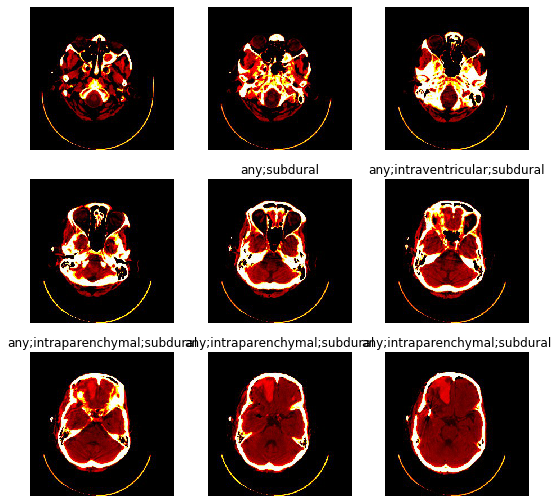

In [8]:
dls.valid.show_batch()

In [9]:
xb,yb = dls.one_batch(); xb.shape

torch.Size([32, 3, 256, 256])

In [10]:
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [11]:
p = get_aug_pipe(128)
p(xb).shape

torch.Size([32, 3, 128, 128])

In [12]:
pipe_update_size(p, 384)
p(xb).shape

torch.Size([32, 3, 384, 384])

## Loss 

### Taken from here: https://github.com/adambielski/siamese-triplet/blob/master/losses.py

In [13]:
#export
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


## Sanity Checking Triple loss

In [14]:
xb,yb = dls.one_batch()

In [15]:
tloss = TripletLoss(margin=0.5)

In [16]:
# Pos = Pos
tloss(xb, xb, xb.flip(dims=[0]))

tensor(0.4054, device='cuda:1')

In [17]:
# Pos = Neg
tloss(xb, xb.flip(dims=[0]), xb)

tensor(0.8283, device='cuda:1')

In [18]:
aug = get_aug_pipe(256)
tloss(xb, aug(xb), xb.flip(dims=[0]))

tensor(3.8162, device='cuda:1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


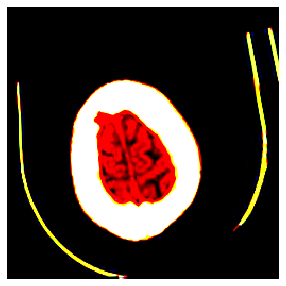

In [19]:
show_image(aug(xb)[0])

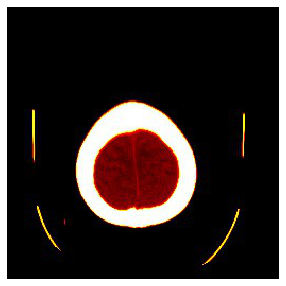

In [20]:
show_image(xb.flip(dims=[0])[0])

## Callbacks

In [21]:
#export
class SSModel(nn.Sequential):
    def __init__(self, model:nn.Sequential): super().__init__(*model)
        
    def features(self, x):
        return self[1][:2](self[0](x))
    
    def logits(self, x):
        return self[1][2:](x)
        
    def forward(self, *args):
        feats = [self.features(x) for x in args]
        logits = [self.logits(x) for x in feats]
        return tuple(feats), tuple(logits)

In [22]:
#export
class CombinedSSLoss(nn.Module):
    def __init__(self, ss_loss_func, orig_loss_func):
        super().__init__()
        store_attr(self, 'ss_loss_func,orig_loss_func')
        
    def forward(self, preds, labels):
        ss_loss = self.ss_loss_func(preds, labels)
        
        feats, (logits_targ, logits_pos) = preds
        orig_loss = self.orig_loss_func(logits_targ, labels)
        
        return ss_loss + orig_loss

In [23]:
#export
class SSCallback(Callback):
    def __init__(self, loss_func, aug_targ=None, aug_pos=None, combined_loss=False):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.loss_func = loss_func
        self.orig_loss_func = None
        self.combined_loss = combined_loss
        
    def begin_fit(self): 
        self.learn.model = SSModel(self.learn.model)
        self.old_loss_func = self.learn.loss_func
        self.learn.loss_func = CombinedSSLoss(self.loss_func, self.learn.loss_func) if self.combined_loss else self.loss_func
    def after_fit(self): 
        self.learn.model = nn.Sequential(*self.learn.model)
        self.learn.loss_func = self.old_loss_func
        
    def set_split(self, split_idx):
        self.aug_targ.split_idx = split_idx
#         self.aug_pos.split_idx = split_idx # always keep augmentation
    def begin_validate(self): self.set_split(1)
    def begin_train(self): self.set_split(0)
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = xb_targ, xb_pos
        

## Triplet Loss

In [24]:
#export
class SSTripletLoss(TripletLoss):
    def forward(self, preds, labels, size_average=True):
        (anchor, positive), logits = preds
        negative = positive.flip(dims=[0])
        return super().forward(anchor, positive, negative, size_average)


## Training

In [25]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(SSTripletLoss())
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[], cbs=cb)


In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,1.677184,4.361921,00:15


## Sanity Check Contrastive Loss

In [27]:
#export
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [28]:
closs = ContrastiveLoss(0.5)

In [29]:
targ = torch.randn(8, 256) # bs x features
aug = targ + 0.1 # bs x feat
targ.shape

torch.Size([8, 256])

In [30]:
labels = torch.zeros(targ.shape[0])
labels[0] = 1

# single target to rest of batch
closs(targ[0], aug, labels)

tensor(0.1600)

In [31]:
# 1-to-1 match targ -> aug. Loss should be 8x higher
labels = torch.ones(targ.shape[0])
closs(targ, aug, labels)

tensor(1.2800)

In [32]:
# single targ -> all rand. Super High Loss
labels = torch.ones(targ.shape[0])
closs(targ[0], aug, labels)

tensor(215.3356)

### Batched contrastive loss

In [33]:
aug_bs = aug.repeat(8,1,1)
aug_bs.shape

torch.Size([8, 8, 256])

In [34]:
losses = []
for i in range(targ.shape[0]):
    bs = targ.shape[0]
    labels = torch.zeros(bs)
    labels[i] = 1 # set current target as the only positive label
    print(labels)
    losses.append(closs(targ[i], aug, labels))
torch.stack(losses).mean()

tensor([1., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1.])


tensor(0.1600)

In [35]:
# Sanity checking - setting wrong target as positive label
losses = []
for i in range(targ.shape[0]):
    bs = targ.shape[0]
    labels = torch.zeros(bs)
    labels[0] = 1 # set current target as the only positive label
    losses.append(closs(targ[i], aug, labels))
losses

[tensor(0.1600),
 tensor(30.2456),
 tensor(32.0196),
 tensor(29.9922),
 tensor(32.6537),
 tensor(27.7380),
 tensor(30.0781),
 tensor(33.7360)]

In [36]:
#export
class BatchContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.loss_func = ContrastiveLoss(margin)
        
    def forward(self, preds, labels):
        (anchor, positive), logits = preds
        
        bs = anchor.shape[0]
        losses = []
        for i in range(bs):
            labels = torch.zeros(bs, device=anchor.device)
            labels[i] = 1 # set current target as the only positive label
            losses.append(self.loss_func(anchor[i], positive, labels))
        return torch.stack(losses).mean()

## Training

In [37]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(BatchContrastiveLoss())
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[], cbs=cb)


In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


## Train Contrastive + Labels

In [48]:
#export
def loss_cont(out, labels, f):
    targ, aug, pred = out
    (anchor, positive), logits = preds
    return f(targ, aug)
    
def loss_class(out, labels, f):
    targ, aug, pred = out
    return f(out[-1], labels)

In [49]:
#export
def accuracy_ss(inp, targ, thresh=0.5, sigmoid=True):
    _, _, inp = inp
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [53]:
size=128
lclass = partial(loss_class, f=get_loss())
lcont = partial(loss_cont, f=BatchContrastiveLoss())


dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(BatchContrastiveLoss(), combined_loss=True)
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[accuracy_ss, lcont, lclass], cbs=cb)


In [54]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_ss,loss_cont,loss_class,time
0,1.100884,1.114898,None,None,None,00:27


ValueError: not enough values to unpack (expected 3, got 2)

In [82]:
import gc
gc.collect()

60

## Export

In [2]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 02_train_01_save_features.ipynb.
Converted 03_train3d.ipynb.
Converted 04_trainfull3d_deprecated.ipynb.
Converted 04_trainfull3d_labels.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 06_seutao_features.ipynb.
Converted 07_adni.ipynb.
Converted 07_adni_01.ipynb.
Converted 08_train_self_supervised-Copy1.ipynb.
Converted 08_train_self_supervised.ipynb.
Converted Tabular_02_FeatureImportance.ipynb.
Converted Untitled.ipynb.
